# DataSet

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import os
import random

import sys

# Download midi library from here: http://deeplearning.net/tutorial/rnnrbm.html
# and do sysn.path.append with it, like below.
# Direct link: http://www.iro.umontreal.ca/~lisa/deep/midi.zip
PATH = '/home/ubuntu/git/music-generation/'
sys.path.append(os.path.join(PATH, 'midi'))

import pretty_midi
from midi_utils import midiread, midiwrite

os.environ["CUDA_VISIBLE_DEVICES"] = '0'


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Binarize the pressed notes
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
    
    # We hardcode 128 -- because we will always use only
    # 128 pitches
    
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, :original_piano_roll_length] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),
                                  midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        """Recomputes the longest sequence constant of the dataset.

        Reads all the midi files from the midi folder and finds the max
        length.
        """
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],
                                self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # -1 because we will shift it
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifted by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,
                                                      max_length=self.longest_sequence_length,
                                                      pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),
                torch.LongTensor(ground_truth_sequence_padded),
                torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0], :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = list(map(lambda x: int(x), lengths_batch_sorted_list))
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, lengths_batch_sorted_list

In [2]:
trainset = NotesGenerationDataset('Nottingham_data/Nottingham/train/')

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=120,
                                              shuffle=True, num_workers=4, drop_last=True)

valset = NotesGenerationDataset('Nottingham_data/Nottingham/valid/', longest_sequence_length=None)

valset_loader = torch.utils.data.DataLoader(valset, batch_size=30, 
                                            shuffle=False, num_workers=4, drop_last=False)

# RNN Model

In [2]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
                
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking, we use the crossentropy
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        
        logits_flatten = binary_logits.view(-1, 2)
        
        return logits_flatten, hidden

In [4]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()

In [5]:
criterion = nn.CrossEntropyLoss().cuda()

criterion_val = nn.CrossEntropyLoss(size_average=False).cuda()

learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# Training

In [22]:
def validate():

    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

        input_sequences_batch_var = input_sequences_batch.cuda()

        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [21]:
clip = 1.0
epochs_number = 120#000000
sample_history = []
best_val_loss = float("inf")
loss_list = list()
val_list = list()

for epoch_number in range(epochs_number):

    current_train_loss = 0
    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()
        
        input_sequences_batch_var = input_sequences_batch.cuda()
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append( loss.item() )
        current_train_loss += loss_list[-1]
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
        
    current_train_loss /= len(trainset_loader)

    current_val_loss = validate()
    val_list.append(current_val_loss)
    
    if current_val_loss < best_val_loss:
        
        torch.save(rnn.state_dict(), 'music_rnn.pth')
        best_val_loss = current_val_loss
    print('EPOCH %d' % epoch_number)
    print('\tTRAIN LOSS: %.4f' % current_train_loss)
    print('\tVAL LOSS: %.4f' % current_val_loss)

/home/ubuntu/src/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


EPOCH 0
	TRAIN LOSS: 0.0926
	VAL LOSS: 0.0926
EPOCH 1
	TRAIN LOSS: 0.0926
	VAL LOSS: 0.0919
EPOCH 2
	TRAIN LOSS: 0.0920
	VAL LOSS: 0.0916
EPOCH 3
	TRAIN LOSS: 0.0924
	VAL LOSS: 0.0914
EPOCH 4
	TRAIN LOSS: 0.0915
	VAL LOSS: 0.0909
EPOCH 5
	TRAIN LOSS: 0.0915
	VAL LOSS: 0.0907
EPOCH 6
	TRAIN LOSS: 0.0909
	VAL LOSS: 0.0902
EPOCH 7
	TRAIN LOSS: 0.0899
	VAL LOSS: 0.0899
EPOCH 8
	TRAIN LOSS: 0.0898
	VAL LOSS: 0.0889
EPOCH 9
	TRAIN LOSS: 0.0892
	VAL LOSS: 0.0884
EPOCH 10
	TRAIN LOSS: 0.0878
	VAL LOSS: 0.0873
EPOCH 11
	TRAIN LOSS: 0.0877
	VAL LOSS: 0.0865
EPOCH 12
	TRAIN LOSS: 0.0856
	VAL LOSS: 0.0861
EPOCH 13
	TRAIN LOSS: 0.0856
	VAL LOSS: 0.0848
EPOCH 14
	TRAIN LOSS: 0.0844
	VAL LOSS: 0.0840
EPOCH 15
	TRAIN LOSS: 0.0835
	VAL LOSS: 0.0830
EPOCH 16
	TRAIN LOSS: 0.0828
	VAL LOSS: 0.0823
EPOCH 17
	TRAIN LOSS: 0.0818
	VAL LOSS: 0.0815
EPOCH 18
	TRAIN LOSS: 0.0811
	VAL LOSS: 0.0808
EPOCH 19
	TRAIN LOSS: 0.0805
	VAL LOSS: 0.0798
EPOCH 20
	TRAIN LOSS: 0.0794
	VAL LOSS: 0.0791
EPOCH 21
	TRAIN LOSS: 0

# Load model

In [3]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
rnn.load_state_dict(torch.load('models/music_rnn.pth'))

In [4]:
def sample_from_piano_rnn(sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
    final_output_sequence = [current_sequence_input.data.squeeze(1)]
    
    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [5]:
testset = NotesGenerationDataset('Nottingham_data/Nottingham/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1, 
                                            shuffle=False, num_workers=4, drop_last=False)

In [6]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()


In [28]:
sample_orig = batch[0].numpy()

In [32]:
sample_orig = sample_orig.reshape((1495, 88))

In [33]:
midiwrite('test0_orig.mid', sample_orig, dt=0.3)

In [ ]:
import matplotlib.pyplot as plt

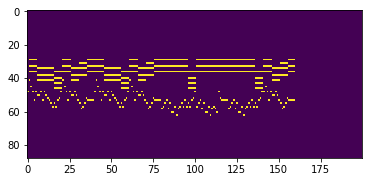

In [41]:
plt.imshow(sample_orig.transpose()[:,:200])

In [34]:
IPython.display.FileLink('test0_orig.mid')

/home/ubuntu/git/music-generation/test0_orig.mid

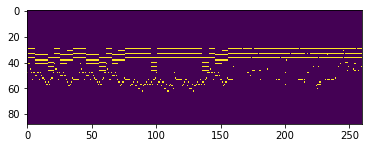

In [35]:
%matplotlib inline


sample = sample_from_piano_rnn(sample_length=100, temperature=0.7, 
                               starting_sequence=input_sequences_batch_var).transpose()
plt.imshow(sample)

In [36]:
sample.shape

(88, 260)

In [37]:
midiwrite('test0.mid', sample.transpose(), dt=0.3)

In [38]:
IPython.display.FileLink('test0.mid')

/home/ubuntu/git/music-generation/test0.mid